In [5]:
import matplotlib.pyplot as plt                        
%matplotlib inline         



###################### Importing "Train" from Bottleneck. ###########################
import numpy as np

bottleneck_features = np.load('bottleneck_features/DogVGG19Data.npz')
train_VGG19 = bottleneck_features['train']
#####################################################################################



############################ Main Model Architecture ################################
from keras.layers import GlobalAveragePooling2D ,Dense ,Conv2D ,Dropout
from keras.models import Sequential

VGG19_model = Sequential()

VGG19_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
VGG19_model.add(Dense(500 ,activation='relu'))
VGG19_model.add(Dropout(0.4))
VGG19_model.add(Dense(133, activation='softmax'))

VGG19_model.summary()
#####################################################################################



####################### Prepairing the Main Model. ##################################
from keras.applications.resnet50 import preprocess_input, decode_predictions
from extract_bottleneck_features import extract_VGG19
from keras.preprocessing import image     
from glob import glob
from tqdm import tqdm



VGG19_model.load_weights('saved_models/weights.best.Resnet50.hdf5')
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]



def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)



def VGG19_prediction(img_path):
    # extract bottleneck features
    bottleneck_featur = extract_VGG19(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG19_model.predict(bottleneck_featur)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]
#####################################################################################



########################## "Human Face Detector" #################################### 
import cv2

def face_detected(img_path):
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0
#####################################################################################



################################## "Dog Detector" ###################################
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

def dog_detected(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))
#####################################################################################



#################################### "Main" #########################################
def main(image_path):
    
    predicted_breed = VGG19_prediction(image_path)
    

    
    if face_detected(image_path):
        print("It seems that a human is detected in the picture.")
        print("And the person looks like a " ,predicted_breed ," dog.")
        
    elif dog_detected(image_path):
        print("Hey it's a dog.")
        print("And it looks like a",predicted_breed ,"dog.")
        
    else:
        print("Neither any human is detected nor any dog detected is detected in the image.")
        
        
    cv_rgb = cv2.imread(image_path)
    cv_rgb = cv2.cvtColor(cv_rgb ,cv2.COLOR_BGR2RGB)
    return plt.imshow(cv_rgb)
####################################################################################

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               256500    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               66633     
Total params: 323,133.0
Trainable params: 323,133.0
Non-trainable params: 0.0
_________________________________________________________________


Hey it's a dog.
And it looks like a Brittany dog.


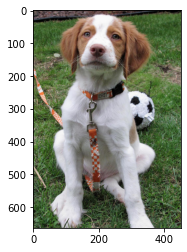

In [6]:
main('images/Brittany_02625.jpg')